# Language

In [43]:
import os
from pathlib import Path
import json
import pickle
from collections import Counter

import tqdm 
from icl.constants import DEVICE, DATA
from icl.language.model import get_model
from icl.language.utils import translate_int_to_str

model = get_model()

Using pad_token, but it is not set yet.


In [16]:
import torch
import numpy as np

validation_set_idxs = np.random.choice(5_000_000, size=10_000, replace=False)
validation_set = []

with open(DATA / "train-5m.jsonl", "r") as f:
    for i, line in tqdm.tqdm(enumerate(f), total=5_000_000):
        if i in validation_set_idxs:
            content = json.loads(line)['contents']
            tokens = model.tokenizer(content)['input_ids']

            if len(tokens) > 1024:
                tokens = tokens[:1024]

            validation_set.append(tokens)

100%|██████████| 5000000/5000000 [00:47<00:00, 106344.43it/s]


In [17]:
import boto3

client = boto3.client('s3')

with open(DATA / 'tokens-10k.pkl', 'wb') as f:
    pickle.dump(validation_set, f)

with open(DATA / 'tokens-10k.pkl','rb') as f:
    client.upload_fileobj(f, 'devinterp', f'other/language/tokens-10k.pkl')

In [18]:
with open(DATA / 'tokens-10k.pkl','rb') as f:
    validation_set = pickle.load(f) 

In [48]:
vocab_size = 5000
vocab = np.arange(vocab_size)
total_trigrams = Counter()
total_trigrams_per_row = Counter()

for tokens in tqdm.tqdm(validation_set):
    trigrams_in_row = set()

    for i in range(len(tokens)-2):
        trigram = tuple(tokens[i:i+3])
        total_trigrams[trigram] += 1
        trigrams_in_row.add(trigram)

    for token in trigrams_in_row:
        total_trigrams_per_row[token] += 1


100%|██████████| 10000/10000 [00:06<00:00, 1515.79it/s]


In [49]:
print("Number of unique trigrams in validation set:", len(total_trigrams))
print("Number of unique trigrams with count > 1:", len([t for t in total_trigrams if total_trigrams[t] > 1]))
print("Number of unique trigrams with count > 2:", len([t for t in total_trigrams if total_trigrams[t] > 2]))
print("Number of unique trigrams that show up in > 1 rows:", len([t for t in total_trigrams if total_trigrams_per_row[t] > 1]))
print("Number of unique trigrams that show up in > 2 rows:", len([t for t in total_trigrams if total_trigrams_per_row[t] > 2]))

Number of unique trigrams in validation set: 2038645
Number of unique trigrams with count > 1: 502141
Number of unique trigrams with count > 2: 272505
Number of unique trigrams that show up in > 1 rows: 432513
Number of unique trigrams that show up in > 2 rows: 234870


In [54]:
common_trigrams = {t for t in total_trigrams if total_trigrams_per_row[t] > 2}

for i, t in enumerate(common_trigrams):
    strs = tuple(translate_int_to_str(t, model))
    print("".join(strs), "\t\t\t", tuple(translate_int_to_str(t, model)))
    if i > 100:
        break

ian refuge 			 ('ian', ' ref', 'uge')
, we've 			 (',', ' we', "'ve")
tool in 			 ('t', 'ool', ' in')
eld. 			 ('e', 'ld', '.')
� t 			 ('�', ' ', 't')
ue, The 			 ('ue', ',', ' The')
ion.
 			 ('ion', '.', '\n')
 day I  			 (' day', ' I', ' ')
 off on  			 (' off', ' on', ' ')
an entirely 			 ('an', ' entire', 'ly')
 put his foot 			 (' put', ' his', ' foot')
 in Japanese Pat 			 (' in', ' Japanese', ' Pat')
ain.
 			 ('ain', '.', '\n')
bot of 			 ('b', 'ot', ' of')
orn the 			 ('orn', ' ', 'the')
 sound,  			 (' sound', ',', ' ')
 an eight 			 (' ', 'an', ' eight')

Clay 			 ('\n', 'Cl', 'ay')
ed Wil 			 ('ed', ' W', 'il')
 Bonn 			 (' B', 'on', 'n')
 Nora 			 (' N', 'or', 'a')
branded 			 ('br', 'and', 'ed')
a. As 			 ('a', '.', ' As')
 been fired 			 (' been', ' f', 'ired')
th-old 			 ('th', '-', 'old')
 or ass 			 (' or', ' ', 'ass')
 skin rash 			 (' skin', ' r', 'ash')
 the break 			 (' ', 'the', ' break')
 outline of 			 (' out', 'line', ' of')
venue,  			 ('venue', ',', ' ')
 

In [66]:
common_trigrams_counts = Counter()
num_total_trigrams = 0
num_included_trigrams = 0

def count_to_freq(counter, num_total):
    indices = list(counter.keys())
    values = list(counter.values())

    # Convert to Tensors
    indices_tensor = torch.tensor(indices).t()  # Transpose to get 2D tensor for indices
    values_tensor = torch.tensor(values) / num_total

    # Create sparse tensor
    sparse_tensor = torch.sparse_coo_tensor(indices_tensor, values_tensor, size=(5000, 5000, 5000))
    return sparse_tensor

last_freq = count_to_freq(common, num_total_trigrams)

def sparse_allclose(sparse_tensor1, sparse_tensor2, atol=1e-8, rtol=1e-5):
    # Check if both have the same number of non-zero elements
    if sparse_tensor1._nnz() != sparse_tensor2._nnz():
        print(f"Number of non-zero elements not equal ({sparse_tensor1._nnz()}, {sparse_tensor2._nnz()})")
        return False
    
    # Sort indices and values
    sparse_tensor1 = sparse_tensor1.coalesce()
    sparse_tensor2 = sparse_tensor2.coalesce()

    # Compare indices
    if not torch.equal(sparse_tensor1.indices(), sparse_tensor2.indices()):
        print(f"Indices not equal ({len(sparse_tensor1.indices())}, {len(sparse_tensor2.indices())})")
        return False

    # Compare values with tolerance
    diff = torch.abs(sparse_tensor1.values() - sparse_tensor2.values())
    print("Diff norm:", diff.norm())
    return torch.all(diff <= atol + rtol * torch.abs(sparse_tensor2.values()))


print("Loading dataset...")
with open(DATA / 'train-5m.jsonl', 'rb') as f:
    for i, row in tqdm.tqdm(enumerate(f.readlines()), total=5_000_000):
        tokens = model.tokenizer(json.loads(row)['contents'])['input_ids']
        
        for j in range(len(tokens)-2):
            num_total_trigrams += 1
            trigram = tuple(tokens[j:j+3])
            
            if trigram in common_trigrams:
                common_trigrams_counts[trigram] += 1
                num_included_trigrams += 1

        if i > 0 and i % 10_000 == 0:
            freq = count_to_freq(common_trigrams_counts, num_included_trigrams)

            if sparse_allclose(last_freq, freq, atol=0, rtol=1e-5):
                print("Early stopping at row", i)
                break

            last_freq = freq

Loading dataset...


  0%|          | 10090/5000000 [00:26<2:52:35, 481.85it/s]

Number of non-zero elements not equal (2038645, 209272)


  0%|          | 20065/5000000 [00:44<3:19:22, 416.31it/s]

Number of non-zero elements not equal (209272, 225057)


  1%|          | 30051/5000000 [01:08<4:10:48, 330.25it/s]

Number of non-zero elements not equal (225057, 229888)


  1%|          | 40094/5000000 [01:30<3:50:43, 358.29it/s]

Number of non-zero elements not equal (229888, 231879)


  1%|          | 50044/5000000 [01:53<5:24:49, 253.99it/s]

Number of non-zero elements not equal (231879, 232880)


  1%|          | 60060/5000000 [02:21<5:30:39, 248.99it/s] 

Number of non-zero elements not equal (232880, 233487)


  1%|▏         | 70060/5000000 [02:45<4:21:37, 314.07it/s]

Number of non-zero elements not equal (233487, 233858)


  2%|▏         | 80106/5000000 [03:04<2:13:08, 615.91it/s] 

Number of non-zero elements not equal (233858, 234094)


  2%|▏         | 90099/5000000 [03:17<2:13:40, 612.20it/s]

Number of non-zero elements not equal (234094, 234273)


  2%|▏         | 100139/5000000 [03:30<2:13:27, 611.94it/s]

Number of non-zero elements not equal (234273, 234387)


  2%|▏         | 110091/5000000 [03:42<2:11:10, 621.33it/s]

Number of non-zero elements not equal (234387, 234480)


  2%|▏         | 120109/5000000 [03:55<2:10:14, 624.46it/s]

Number of non-zero elements not equal (234480, 234552)


  3%|▎         | 130116/5000000 [04:09<2:09:41, 625.79it/s]

Number of non-zero elements not equal (234552, 234604)


  3%|▎         | 140119/5000000 [04:22<2:17:57, 587.11it/s]

Number of non-zero elements not equal (234604, 234633)


  3%|▎         | 150131/5000000 [04:35<2:31:17, 534.28it/s]

Number of non-zero elements not equal (234633, 234670)


  3%|▎         | 160076/5000000 [04:48<2:13:35, 603.81it/s]

Number of non-zero elements not equal (234670, 234690)


  3%|▎         | 170093/5000000 [05:01<2:21:09, 570.26it/s]

Number of non-zero elements not equal (234690, 234711)


  4%|▎         | 180144/5000000 [05:15<2:10:03, 617.68it/s]

Number of non-zero elements not equal (234711, 234731)


  4%|▍         | 190117/5000000 [05:29<2:07:42, 627.76it/s]

Number of non-zero elements not equal (234731, 234742)


  4%|▍         | 200111/5000000 [05:42<2:28:03, 540.33it/s]

Number of non-zero elements not equal (234742, 234759)


  4%|▍         | 210081/5000000 [05:56<2:19:03, 574.10it/s]

Number of non-zero elements not equal (234759, 234767)


  4%|▍         | 220141/5000000 [06:10<2:10:14, 611.64it/s]

Number of non-zero elements not equal (234767, 234777)


  5%|▍         | 230085/5000000 [06:23<2:10:07, 610.93it/s]

Number of non-zero elements not equal (234777, 234783)


  5%|▍         | 240097/5000000 [06:36<2:07:23, 622.72it/s]

Number of non-zero elements not equal (234783, 234791)


  5%|▌         | 250150/5000000 [06:49<2:05:21, 631.51it/s]

Number of non-zero elements not equal (234791, 234794)


  5%|▌         | 260129/5000000 [07:02<2:06:59, 622.11it/s]

Number of non-zero elements not equal (234794, 234798)


  5%|▌         | 270077/5000000 [07:14<2:10:15, 605.23it/s]

Number of non-zero elements not equal (234798, 234806)


  6%|▌         | 280075/5000000 [07:28<2:19:47, 562.76it/s]

Number of non-zero elements not equal (234806, 234810)


  6%|▌         | 290114/5000000 [07:41<2:08:24, 611.28it/s]

Number of non-zero elements not equal (234810, 234813)


  6%|▌         | 300094/5000000 [07:55<2:03:01, 636.69it/s]

Number of non-zero elements not equal (234813, 234819)


  6%|▌         | 310113/5000000 [08:08<2:10:02, 601.05it/s]

Number of non-zero elements not equal (234819, 234824)


  6%|▋         | 320138/5000000 [08:22<2:14:45, 578.82it/s]

Number of non-zero elements not equal (234824, 234825)


  7%|▋         | 330118/5000000 [08:35<2:13:40, 582.25it/s]

Number of non-zero elements not equal (234825, 234827)


  7%|▋         | 340127/5000000 [08:49<2:11:50, 589.06it/s]

Number of non-zero elements not equal (234827, 234830)


  7%|▋         | 350076/5000000 [09:03<2:21:01, 549.51it/s]

Number of non-zero elements not equal (234830, 234832)


  7%|▋         | 360107/5000000 [09:17<2:15:56, 568.88it/s]

Number of non-zero elements not equal (234832, 234834)


  7%|▋         | 370082/5000000 [09:31<2:06:38, 609.29it/s]

Number of non-zero elements not equal (234834, 234836)


  8%|▊         | 380139/5000000 [09:44<2:15:56, 566.42it/s]

Number of non-zero elements not equal (234836, 234838)


  8%|▊         | 390107/5000000 [09:58<2:16:10, 564.18it/s]

Number of non-zero elements not equal (234838, 234839)


  8%|▊         | 400113/5000000 [10:12<2:09:27, 592.20it/s]

Number of non-zero elements not equal (234839, 234840)


  8%|▊         | 410111/5000000 [10:26<2:15:01, 566.53it/s]

Number of non-zero elements not equal (234840, 234841)


  8%|▊         | 420101/5000000 [10:40<2:03:09, 619.75it/s]

Number of non-zero elements not equal (234841, 234843)


  9%|▊         | 430123/5000000 [10:54<2:19:44, 545.03it/s]

Diff norm: tensor(2.4497e-05)


  9%|▉         | 440122/5000000 [11:07<2:18:35, 548.39it/s]

Diff norm: tensor(2.1298e-05)


  9%|▉         | 450091/5000000 [11:21<1:59:03, 636.91it/s]

Number of non-zero elements not equal (234843, 234844)


  9%|▉         | 460137/5000000 [11:35<2:11:45, 574.24it/s]

Number of non-zero elements not equal (234844, 234845)


  9%|▉         | 470086/5000000 [11:48<2:06:12, 598.19it/s]

Number of non-zero elements not equal (234845, 234848)


 10%|▉         | 480077/5000000 [12:02<2:01:05, 622.09it/s]

Number of non-zero elements not equal (234848, 234849)


 10%|▉         | 490103/5000000 [12:15<2:07:47, 588.17it/s]

Diff norm: tensor(1.9824e-05)


 10%|█         | 500095/5000000 [12:28<2:06:46, 591.56it/s]

Number of non-zero elements not equal (234849, 234851)


 10%|█         | 510152/5000000 [12:41<1:59:08, 628.10it/s]

Number of non-zero elements not equal (234851, 234853)


 10%|█         | 520102/5000000 [12:54<1:59:45, 623.49it/s]

Number of non-zero elements not equal (234853, 234855)


 11%|█         | 530114/5000000 [13:08<2:11:11, 567.88it/s]

Number of non-zero elements not equal (234855, 234856)


 11%|█         | 540132/5000000 [13:21<2:14:22, 553.18it/s]

Number of non-zero elements not equal (234856, 234858)


 11%|█         | 550136/5000000 [13:34<2:15:58, 545.43it/s]

Diff norm: tensor(2.0323e-05)


 11%|█         | 560077/5000000 [13:48<2:29:57, 493.47it/s]

Diff norm: tensor(1.6380e-05)


 11%|█▏        | 570082/5000000 [14:02<2:15:02, 546.72it/s]

Number of non-zero elements not equal (234858, 234859)


 12%|█▏        | 580096/5000000 [14:16<2:19:27, 528.24it/s]

Diff norm: tensor(1.5655e-05)


 12%|█▏        | 590076/5000000 [14:30<2:10:42, 562.29it/s]

Number of non-zero elements not equal (234859, 234860)


 12%|█▏        | 600071/5000000 [14:45<2:31:53, 482.81it/s]

Diff norm: tensor(1.4232e-05)


 12%|█▏        | 610073/5000000 [14:59<2:18:35, 527.91it/s]

Diff norm: tensor(1.7088e-05)


 12%|█▏        | 620077/5000000 [15:13<2:29:14, 489.13it/s]

Diff norm: tensor(2.8830e-05)


 13%|█▎        | 630103/5000000 [15:27<2:09:51, 560.84it/s]

Diff norm: tensor(1.5735e-05)


 13%|█▎        | 640135/5000000 [15:41<2:18:48, 523.48it/s]

Diff norm: tensor(2.0791e-05)


 13%|█▎        | 650131/5000000 [15:55<2:15:30, 534.99it/s]

Diff norm: tensor(1.4492e-05)


 13%|█▎        | 660073/5000000 [16:09<2:21:03, 512.78it/s]

Diff norm: tensor(1.3071e-05)


 13%|█▎        | 670105/5000000 [16:23<2:26:44, 491.79it/s]

Diff norm: tensor(2.1990e-05)


 14%|█▎        | 680104/5000000 [16:37<2:06:25, 569.46it/s]

Diff norm: tensor(1.3788e-05)


 14%|█▍        | 690137/5000000 [16:51<2:08:12, 560.28it/s]

Diff norm: tensor(1.4471e-05)


 14%|█▍        | 700122/5000000 [17:04<2:16:05, 526.58it/s]

Diff norm: tensor(1.3230e-05)


 14%|█▍        | 710141/5000000 [17:17<2:13:24, 535.95it/s]

Diff norm: tensor(1.4523e-05)


 14%|█▍        | 720136/5000000 [17:31<2:06:24, 564.30it/s]

Diff norm: tensor(1.2618e-05)


 15%|█▍        | 730071/5000000 [17:44<2:15:41, 524.49it/s]

Diff norm: tensor(1.4686e-05)


 15%|█▍        | 740088/5000000 [17:58<1:59:05, 596.15it/s]

Number of non-zero elements not equal (234860, 234861)


 15%|█▌        | 750134/5000000 [18:12<2:05:20, 565.11it/s]

Diff norm: tensor(1.7272e-05)


 15%|█▌        | 760115/5000000 [18:25<2:01:48, 580.09it/s]

Diff norm: tensor(1.5865e-05)


 15%|█▌        | 770109/5000000 [18:38<2:12:50, 530.70it/s]

Diff norm: tensor(1.1147e-05)


 16%|█▌        | 780110/5000000 [18:51<2:11:05, 536.50it/s]

Diff norm: tensor(1.3328e-05)


 16%|█▌        | 790076/5000000 [19:04<2:04:33, 563.29it/s]

Diff norm: tensor(3.4391e-05)


 16%|█▌        | 800075/5000000 [19:18<2:01:43, 575.08it/s]

Diff norm: tensor(2.2086e-05)


 16%|█▌        | 810121/5000000 [19:31<2:00:11, 581.00it/s]

Diff norm: tensor(1.1865e-05)


 16%|█▋        | 820125/5000000 [19:44<2:01:13, 574.67it/s]

Diff norm: tensor(1.3131e-05)


 17%|█▋        | 830104/5000000 [19:57<2:14:37, 516.21it/s]

Diff norm: tensor(1.0844e-05)


 17%|█▋        | 840088/5000000 [20:11<1:59:39, 579.45it/s]

Diff norm: tensor(1.2216e-05)


 17%|█▋        | 850082/5000000 [20:24<2:12:17, 522.83it/s]

Diff norm: tensor(1.2292e-05)


 17%|█▋        | 860078/5000000 [20:38<2:24:02, 479.01it/s]

Diff norm: tensor(1.1364e-05)


 17%|█▋        | 870080/5000000 [20:53<2:18:28, 497.05it/s]

Diff norm: tensor(1.3812e-05)


 18%|█▊        | 880113/5000000 [21:08<2:12:19, 518.88it/s]

Diff norm: tensor(1.1070e-05)


 18%|█▊        | 890127/5000000 [21:23<2:26:47, 466.64it/s]

Diff norm: tensor(2.8140e-05)


 18%|█▊        | 900103/5000000 [21:38<2:22:48, 478.50it/s]

Diff norm: tensor(1.0876e-05)


 18%|█▊        | 910112/5000000 [21:53<2:18:10, 493.32it/s]

Diff norm: tensor(1.5496e-05)


 18%|█▊        | 920089/5000000 [22:07<2:27:51, 459.89it/s]

Diff norm: tensor(1.0391e-05)


 19%|█▊        | 930083/5000000 [22:22<2:23:23, 473.07it/s]

Diff norm: tensor(1.0922e-05)


 19%|█▉        | 940090/5000000 [22:37<2:09:26, 522.73it/s]

Diff norm: tensor(9.9351e-06)


 19%|█▉        | 950081/5000000 [22:52<2:08:13, 526.38it/s]

Diff norm: tensor(1.0868e-05)


 19%|█▉        | 960095/5000000 [23:07<2:07:21, 528.69it/s]

Diff norm: tensor(2.0516e-05)


 19%|█▉        | 970117/5000000 [23:21<1:52:34, 596.63it/s]

Number of non-zero elements not equal (234861, 234862)


 20%|█▉        | 980142/5000000 [23:35<2:06:50, 528.20it/s]

Diff norm: tensor(1.0104e-05)


 20%|█▉        | 990086/5000000 [23:50<1:53:42, 587.79it/s]

Number of non-zero elements not equal (234862, 234863)


 20%|██        | 1000129/5000000 [24:04<2:04:12, 536.71it/s]

Diff norm: tensor(9.4838e-06)


 20%|██        | 1010081/5000000 [24:18<2:06:35, 525.30it/s]

Diff norm: tensor(1.1510e-05)


 20%|██        | 1020101/5000000 [24:32<2:07:44, 519.27it/s]

Diff norm: tensor(8.9385e-06)


 21%|██        | 1030144/5000000 [24:46<2:02:07, 541.79it/s]

Diff norm: tensor(9.2436e-06)


 21%|██        | 1040088/5000000 [24:59<2:05:28, 526.01it/s]

Diff norm: tensor(9.0781e-06)


 21%|██        | 1050135/5000000 [25:14<2:05:32, 524.36it/s]

Diff norm: tensor(9.8736e-06)


 21%|██        | 1060074/5000000 [25:28<2:07:48, 513.78it/s]

Diff norm: tensor(9.2828e-06)


 21%|██▏       | 1070129/5000000 [25:43<2:03:50, 528.90it/s]

Diff norm: tensor(7.8734e-06)


 22%|██▏       | 1080078/5000000 [25:57<2:14:13, 486.74it/s]

Diff norm: tensor(1.6023e-05)


 22%|██▏       | 1090089/5000000 [26:12<2:03:06, 529.37it/s]

Diff norm: tensor(1.0360e-05)


 22%|██▏       | 1100097/5000000 [26:27<2:14:33, 483.06it/s]

Diff norm: tensor(9.2618e-06)


 22%|██▏       | 1110082/5000000 [26:42<2:12:43, 488.50it/s]

Diff norm: tensor(7.6506e-06)


 22%|██▏       | 1120129/5000000 [26:57<2:00:07, 538.29it/s]

Diff norm: tensor(1.1634e-05)


 23%|██▎       | 1130133/5000000 [27:11<2:01:56, 528.90it/s]

Diff norm: tensor(8.6709e-06)


 23%|██▎       | 1140116/5000000 [27:25<1:56:59, 549.91it/s]

Diff norm: tensor(1.1328e-05)


 23%|██▎       | 1150071/5000000 [27:39<2:15:16, 474.34it/s]

Diff norm: tensor(9.9787e-06)


 23%|██▎       | 1160087/5000000 [27:54<2:11:37, 486.23it/s]

Diff norm: tensor(7.9954e-06)


 23%|██▎       | 1170095/5000000 [28:10<2:16:34, 467.39it/s]

Diff norm: tensor(9.7890e-06)


 24%|██▎       | 1180078/5000000 [28:25<2:06:22, 503.81it/s]

Diff norm: tensor(8.0066e-06)


 24%|██▍       | 1190096/5000000 [28:39<2:10:13, 487.63it/s]

Diff norm: tensor(1.0386e-05)


 24%|██▍       | 1200105/5000000 [28:55<2:23:43, 440.62it/s]

Diff norm: tensor(1.1523e-05)


 24%|██▍       | 1210091/5000000 [29:10<2:18:41, 455.41it/s]

Diff norm: tensor(1.1208e-05)


 24%|██▍       | 1220140/5000000 [29:25<2:03:17, 510.99it/s]

Diff norm: tensor(8.4069e-06)


 25%|██▍       | 1230099/5000000 [29:41<2:23:29, 437.85it/s]

Diff norm: tensor(8.4263e-06)


 25%|██▍       | 1240084/5000000 [29:56<2:33:55, 407.10it/s]

Diff norm: tensor(7.8902e-06)


 25%|██▌       | 1250077/5000000 [30:11<2:10:27, 479.06it/s]

Diff norm: tensor(8.3964e-06)


 25%|██▌       | 1260118/5000000 [30:26<1:58:40, 525.22it/s]

Diff norm: tensor(7.7447e-06)


 25%|██▌       | 1270099/5000000 [30:41<2:15:13, 459.69it/s]

Diff norm: tensor(7.5753e-06)


 26%|██▌       | 1280097/5000000 [30:57<2:13:15, 465.27it/s]

Diff norm: tensor(6.6334e-06)


 26%|██▌       | 1290098/5000000 [31:12<2:08:22, 481.64it/s]

Diff norm: tensor(1.0590e-05)


 26%|██▌       | 1300117/5000000 [31:27<2:00:18, 512.57it/s]

Diff norm: tensor(1.8986e-05)


 26%|██▌       | 1310135/5000000 [31:42<1:59:23, 515.12it/s]

Diff norm: tensor(7.3326e-06)


 26%|██▋       | 1320078/5000000 [31:58<1:55:17, 531.94it/s]

Diff norm: tensor(7.5575e-06)


 27%|██▋       | 1330059/5000000 [32:12<2:26:12, 418.36it/s]

Diff norm: tensor(8.3711e-06)


 27%|██▋       | 1340117/5000000 [32:28<2:17:08, 444.81it/s]

Diff norm: tensor(1.0303e-05)


 27%|██▋       | 1350084/5000000 [32:44<2:14:24, 452.61it/s]

Diff norm: tensor(1.1270e-05)


 27%|██▋       | 1360107/5000000 [33:00<2:06:49, 478.36it/s]

Diff norm: tensor(6.6155e-06)


 27%|██▋       | 1370103/5000000 [33:16<2:16:55, 441.82it/s]

Diff norm: tensor(7.7848e-06)


 28%|██▊       | 1380123/5000000 [33:31<2:08:33, 469.26it/s]

Diff norm: tensor(7.5316e-06)


 28%|██▊       | 1390086/5000000 [33:47<2:00:45, 498.25it/s]

Diff norm: tensor(8.3994e-06)


 28%|██▊       | 1400096/5000000 [34:02<2:02:22, 490.28it/s]

Diff norm: tensor(6.8086e-06)


 28%|██▊       | 1410071/5000000 [34:18<2:10:07, 459.79it/s]

Diff norm: tensor(1.2115e-05)


 28%|██▊       | 1420071/5000000 [34:34<2:06:20, 472.26it/s]

Diff norm: tensor(8.2499e-06)


 29%|██▊       | 1430089/5000000 [34:50<2:04:55, 476.30it/s]

Diff norm: tensor(6.5364e-06)


 29%|██▉       | 1440146/5000000 [35:04<1:37:43, 607.16it/s]

Number of non-zero elements not equal (234863, 234864)


 29%|██▉       | 1450075/5000000 [35:18<2:07:12, 465.08it/s]

Diff norm: tensor(7.5388e-06)


 29%|██▉       | 1460112/5000000 [35:34<2:02:40, 480.96it/s]

Diff norm: tensor(6.2007e-06)


 29%|██▉       | 1470134/5000000 [35:49<2:00:53, 486.64it/s]

Diff norm: tensor(8.6858e-06)


 30%|██▉       | 1480121/5000000 [36:04<1:55:36, 507.47it/s]

Diff norm: tensor(6.6603e-06)


 30%|██▉       | 1490074/5000000 [36:19<1:48:46, 537.80it/s]

Diff norm: tensor(7.4805e-06)


 30%|███       | 1500109/5000000 [36:33<2:07:25, 457.78it/s]

Diff norm: tensor(6.0626e-06)


 30%|███       | 1510129/5000000 [36:48<2:02:25, 475.10it/s]

Diff norm: tensor(8.1260e-06)


 30%|███       | 1520083/5000000 [37:03<1:58:52, 487.90it/s]

Diff norm: tensor(6.2236e-06)


 31%|███       | 1530082/5000000 [37:19<2:08:22, 450.47it/s]

Diff norm: tensor(5.9273e-06)


 31%|███       | 1540125/5000000 [37:36<2:04:24, 463.53it/s]

Diff norm: tensor(5.9894e-06)


 31%|███       | 1550128/5000000 [37:51<2:01:33, 473.02it/s]

Diff norm: tensor(6.7209e-06)


 31%|███       | 1560068/5000000 [38:07<2:02:52, 466.62it/s]

Diff norm: tensor(6.5729e-06)


 31%|███▏      | 1570066/5000000 [38:22<2:19:20, 410.25it/s]

Diff norm: tensor(1.2039e-05)


 32%|███▏      | 1580084/5000000 [38:37<1:47:33, 529.95it/s]

Diff norm: tensor(6.7793e-06)


 32%|███▏      | 1590066/5000000 [38:52<1:48:54, 521.85it/s]

Diff norm: tensor(6.3066e-06)


 32%|███▏      | 1600082/5000000 [39:07<1:58:44, 477.22it/s]

Diff norm: tensor(6.4644e-06)


 32%|███▏      | 1610091/5000000 [39:23<1:59:26, 473.04it/s]

Diff norm: tensor(6.6623e-06)


 32%|███▏      | 1620070/5000000 [39:39<1:58:51, 473.94it/s]

Diff norm: tensor(1.0407e-05)


 33%|███▎      | 1630101/5000000 [39:54<1:56:37, 481.61it/s]

Diff norm: tensor(5.5689e-06)


 33%|███▎      | 1640101/5000000 [40:09<1:47:42, 519.92it/s]

Diff norm: tensor(7.3848e-06)


 33%|███▎      | 1650122/5000000 [40:22<1:38:44, 565.40it/s]

Diff norm: tensor(6.5169e-06)


 33%|███▎      | 1660087/5000000 [40:35<1:36:27, 577.06it/s]

Diff norm: tensor(6.6342e-06)


 33%|███▎      | 1670131/5000000 [40:48<1:36:08, 577.21it/s]

Diff norm: tensor(7.6492e-06)


 34%|███▎      | 1680079/5000000 [41:01<1:37:10, 569.38it/s]

Diff norm: tensor(6.3137e-06)


 34%|███▍      | 1690119/5000000 [41:14<1:35:48, 575.73it/s]

Diff norm: tensor(5.2782e-06)


 34%|███▍      | 1700076/5000000 [41:27<1:39:29, 552.78it/s]

Diff norm: tensor(7.2172e-06)


 34%|███▍      | 1710134/5000000 [41:41<1:40:38, 544.81it/s]

Diff norm: tensor(6.2275e-06)


 34%|███▍      | 1720143/5000000 [41:55<1:43:39, 527.36it/s]

Diff norm: tensor(5.8672e-06)


 35%|███▍      | 1730149/5000000 [42:09<1:55:21, 472.45it/s]

Diff norm: tensor(9.7400e-06)


 35%|███▍      | 1740094/5000000 [42:23<1:44:39, 519.13it/s]

Diff norm: tensor(1.3971e-05)


 35%|███▌      | 1750143/5000000 [42:36<1:36:27, 561.49it/s]

Diff norm: tensor(1.7003e-05)


 35%|███▌      | 1760112/5000000 [42:49<1:34:59, 568.42it/s]

Diff norm: tensor(6.3832e-06)


 35%|███▌      | 1770150/5000000 [43:02<1:30:18, 596.12it/s]

Diff norm: tensor(4.8593e-06)


 36%|███▌      | 1780125/5000000 [43:15<1:36:37, 555.42it/s]

Diff norm: tensor(6.1517e-06)


 36%|███▌      | 1790102/5000000 [43:27<1:28:58, 601.32it/s]

Diff norm: tensor(6.1663e-06)


 36%|███▌      | 1800102/5000000 [43:40<1:35:47, 556.71it/s]

Diff norm: tensor(5.5855e-06)


 36%|███▌      | 1810149/5000000 [43:53<1:34:53, 560.31it/s]

Diff norm: tensor(5.3857e-06)


 36%|███▋      | 1820093/5000000 [44:05<1:31:59, 576.15it/s]

Diff norm: tensor(7.9505e-06)


 37%|███▋      | 1830141/5000000 [44:18<1:30:25, 584.26it/s]

Diff norm: tensor(6.4840e-06)


 37%|███▋      | 1840129/5000000 [44:31<1:29:38, 587.49it/s]

Diff norm: tensor(5.7712e-06)


 37%|███▋      | 1850114/5000000 [44:44<1:29:58, 583.43it/s]

Diff norm: tensor(5.8145e-06)


 37%|███▋      | 1860138/5000000 [44:57<1:30:17, 579.62it/s]

Diff norm: tensor(5.2416e-06)


 37%|███▋      | 1870116/5000000 [45:09<1:30:26, 576.79it/s]

Diff norm: tensor(6.1024e-06)


 38%|███▊      | 1880137/5000000 [45:22<1:27:36, 593.56it/s]

Diff norm: tensor(4.9427e-06)


 38%|███▊      | 1890144/5000000 [45:35<1:27:51, 589.92it/s]

Diff norm: tensor(4.7105e-06)


 38%|███▊      | 1900148/5000000 [45:47<1:28:40, 582.67it/s]

Diff norm: tensor(5.3248e-06)


 38%|███▊      | 1910135/5000000 [46:00<1:30:50, 566.92it/s]

Diff norm: tensor(5.9506e-06)


 38%|███▊      | 1920139/5000000 [46:13<1:28:06, 582.54it/s]

Diff norm: tensor(5.7481e-06)


 39%|███▊      | 1930147/5000000 [46:26<1:29:06, 574.17it/s]

Diff norm: tensor(6.2870e-06)


 39%|███▉      | 1940090/5000000 [46:38<1:26:32, 589.29it/s]

Diff norm: tensor(4.4982e-06)


 39%|███▉      | 1950142/5000000 [46:51<1:29:35, 567.41it/s]

Diff norm: tensor(4.2013e-06)


 39%|███▉      | 1960134/5000000 [47:04<1:26:03, 588.71it/s]

Diff norm: tensor(4.8684e-06)


 39%|███▉      | 1970093/5000000 [47:17<1:27:02, 580.18it/s]

Diff norm: tensor(8.7200e-06)


 40%|███▉      | 1980146/5000000 [47:30<1:29:05, 564.89it/s]

Diff norm: tensor(4.5751e-06)


 40%|███▉      | 1990081/5000000 [47:42<1:33:32, 536.26it/s]

Diff norm: tensor(5.6862e-06)


 40%|████      | 2000080/5000000 [47:55<1:26:28, 578.18it/s]

Diff norm: tensor(4.9706e-06)


 40%|████      | 2010092/5000000 [48:08<1:25:48, 580.70it/s]

Diff norm: tensor(4.6022e-06)


 40%|████      | 2020072/5000000 [48:21<1:29:46, 553.21it/s]

Diff norm: tensor(5.7745e-06)


 41%|████      | 2030143/5000000 [48:34<1:27:45, 563.98it/s]

Diff norm: tensor(4.2091e-06)


 41%|████      | 2040085/5000000 [48:47<1:39:00, 498.27it/s]

Diff norm: tensor(7.1977e-06)


 41%|████      | 2050134/5000000 [49:00<1:21:53, 600.33it/s]

Diff norm: tensor(7.5135e-06)


 41%|████      | 2060092/5000000 [49:13<1:24:39, 578.81it/s]

Diff norm: tensor(4.7940e-06)


 41%|████▏     | 2070112/5000000 [49:25<1:24:25, 578.43it/s]

Diff norm: tensor(7.4963e-06)


 42%|████▏     | 2080073/5000000 [49:38<1:35:48, 507.93it/s]

Diff norm: tensor(4.6245e-06)


 42%|████▏     | 2090088/5000000 [49:51<1:26:56, 557.87it/s]

Diff norm: tensor(4.7076e-06)


 42%|████▏     | 2100140/5000000 [50:04<1:21:58, 589.62it/s]

Diff norm: tensor(4.8524e-06)


 42%|████▏     | 2110138/5000000 [50:17<1:25:54, 560.60it/s]

Diff norm: tensor(4.2541e-06)


 42%|████▏     | 2120102/5000000 [50:30<1:24:22, 568.90it/s]

Diff norm: tensor(4.7482e-06)


 43%|████▎     | 2130110/5000000 [50:43<1:20:52, 591.41it/s]

Diff norm: tensor(5.1959e-06)


 43%|████▎     | 2140055/5000000 [50:55<1:28:24, 539.13it/s]

Diff norm: tensor(6.5047e-06)


 43%|████▎     | 2150130/5000000 [51:08<1:19:59, 593.73it/s]

Diff norm: tensor(4.2700e-06)


 43%|████▎     | 2160092/5000000 [51:21<1:20:42, 586.44it/s]

Diff norm: tensor(6.7046e-06)


 43%|████▎     | 2170108/5000000 [51:33<1:20:22, 586.87it/s]

Diff norm: tensor(5.3732e-06)


 44%|████▎     | 2180103/5000000 [51:46<1:20:56, 580.64it/s]

Diff norm: tensor(4.2480e-06)


 44%|████▍     | 2190080/5000000 [51:59<1:22:55, 564.75it/s]

Diff norm: tensor(6.2714e-06)


 44%|████▍     | 2200093/5000000 [52:12<1:21:09, 575.02it/s]

Diff norm: tensor(5.3147e-06)


 44%|████▍     | 2210106/5000000 [52:24<1:20:33, 577.21it/s]

Diff norm: tensor(4.0158e-06)


 44%|████▍     | 2220080/5000000 [52:37<1:18:51, 587.49it/s]

Diff norm: tensor(4.4260e-06)


 45%|████▍     | 2230078/5000000 [52:50<1:26:26, 534.03it/s]

Diff norm: tensor(8.3824e-06)


 45%|████▍     | 2240114/5000000 [53:02<1:18:42, 584.46it/s]

Diff norm: tensor(4.9300e-06)


 45%|████▌     | 2250136/5000000 [53:15<1:18:06, 586.76it/s]

Diff norm: tensor(5.2407e-06)


 45%|████▌     | 2260133/5000000 [53:28<1:17:07, 592.10it/s]

Diff norm: tensor(4.2985e-06)


 45%|████▌     | 2270096/5000000 [53:41<1:20:50, 562.85it/s]

Diff norm: tensor(6.9166e-06)


 46%|████▌     | 2280106/5000000 [53:53<1:17:39, 583.67it/s]

Diff norm: tensor(4.5429e-06)


 46%|████▌     | 2290076/5000000 [54:06<1:21:13, 556.06it/s]

Diff norm: tensor(4.1242e-06)


 46%|████▌     | 2300123/5000000 [54:19<1:17:12, 582.77it/s]

Diff norm: tensor(4.1157e-06)


 46%|████▌     | 2310077/5000000 [54:32<1:24:49, 528.52it/s]

Diff norm: tensor(3.8367e-06)


 46%|████▋     | 2320101/5000000 [54:44<1:14:16, 601.36it/s]

Diff norm: tensor(6.0429e-06)


 47%|████▋     | 2330136/5000000 [54:57<1:16:33, 581.23it/s]

Diff norm: tensor(5.0837e-06)


 47%|████▋     | 2340128/5000000 [55:10<1:17:49, 569.61it/s]

Diff norm: tensor(4.2372e-06)


 47%|████▋     | 2350091/5000000 [55:23<1:15:16, 586.66it/s]

Diff norm: tensor(4.0999e-06)


 47%|████▋     | 2360131/5000000 [55:35<1:14:04, 593.91it/s]

Diff norm: tensor(4.3337e-06)


 47%|████▋     | 2370148/5000000 [55:48<1:16:02, 576.38it/s]

Diff norm: tensor(3.7111e-06)


 48%|████▊     | 2380077/5000000 [56:01<1:14:00, 589.95it/s]

Diff norm: tensor(5.2342e-06)


 48%|████▊     | 2390077/5000000 [56:13<1:24:46, 513.13it/s]

Diff norm: tensor(5.2542e-06)


 48%|████▊     | 2400086/5000000 [56:26<1:13:31, 589.40it/s]

Diff norm: tensor(2.1679e-05)


 48%|████▊     | 2410081/5000000 [56:39<1:13:06, 590.40it/s]

Diff norm: tensor(3.6987e-06)


 48%|████▊     | 2420142/5000000 [56:52<1:13:28, 585.22it/s]

Diff norm: tensor(4.0129e-06)


 49%|████▊     | 2430082/5000000 [57:04<1:13:55, 579.35it/s]

Diff norm: tensor(3.4718e-06)


 49%|████▉     | 2440133/5000000 [57:17<1:15:04, 568.26it/s]

Diff norm: tensor(4.3437e-06)


 49%|████▉     | 2450078/5000000 [57:30<1:20:49, 525.83it/s]

Diff norm: tensor(3.9130e-06)


 49%|████▉     | 2460088/5000000 [57:43<1:09:47, 606.57it/s]

Diff norm: tensor(3.6736e-06)


 49%|████▉     | 2470098/5000000 [57:55<1:19:33, 529.95it/s]

Diff norm: tensor(4.8539e-06)


 50%|████▉     | 2480141/5000000 [58:08<1:12:08, 582.15it/s]

Diff norm: tensor(4.4720e-06)


 50%|████▉     | 2490077/5000000 [58:21<1:13:47, 566.85it/s]

Diff norm: tensor(5.3594e-06)


 50%|█████     | 2500088/5000000 [58:33<1:11:58, 578.90it/s]

Diff norm: tensor(4.5139e-06)


 50%|█████     | 2510141/5000000 [58:46<1:12:18, 573.93it/s]

Diff norm: tensor(3.5071e-06)


 50%|█████     | 2520098/5000000 [58:59<1:10:23, 587.15it/s]

Diff norm: tensor(3.6329e-06)


 51%|█████     | 2530122/5000000 [59:11<1:09:17, 594.11it/s]

Diff norm: tensor(4.3443e-06)


 51%|█████     | 2540103/5000000 [59:24<1:13:46, 555.72it/s]

Diff norm: tensor(4.7345e-06)


 51%|█████     | 2550116/5000000 [59:36<1:09:07, 590.68it/s]

Diff norm: tensor(4.0566e-06)


 51%|█████     | 2560129/5000000 [59:49<1:08:19, 595.18it/s]

Diff norm: tensor(4.6241e-06)


 51%|█████▏    | 2570151/5000000 [1:00:02<1:08:58, 587.18it/s]

Diff norm: tensor(4.5929e-06)


 52%|█████▏    | 2580080/5000000 [1:00:14<1:12:15, 558.20it/s]

Diff norm: tensor(3.9443e-06)


 52%|█████▏    | 2590115/5000000 [1:00:27<1:08:39, 585.05it/s]

Diff norm: tensor(3.4456e-06)


 52%|█████▏    | 2600120/5000000 [1:00:39<1:07:26, 593.13it/s]

Diff norm: tensor(3.9526e-06)


 52%|█████▏    | 2610130/5000000 [1:00:52<1:11:23, 557.92it/s]

Diff norm: tensor(4.0774e-06)


 52%|█████▏    | 2620114/5000000 [1:01:05<1:06:26, 597.03it/s]

Diff norm: tensor(8.3458e-06)


 53%|█████▎    | 2630122/5000000 [1:01:17<1:07:19, 586.70it/s]

Diff norm: tensor(3.4831e-06)


 53%|█████▎    | 2640070/5000000 [1:01:31<1:22:17, 477.92it/s]

Diff norm: tensor(3.4113e-06)


 53%|█████▎    | 2650069/5000000 [1:01:45<1:32:14, 424.61it/s]

Number of non-zero elements not equal (234864, 234869)


 53%|█████▎    | 2660102/5000000 [1:02:01<1:15:34, 516.02it/s]

Diff norm: tensor(3.7278e-06)


 53%|█████▎    | 2670094/5000000 [1:02:16<1:24:32, 459.31it/s]

Diff norm: tensor(5.2618e-06)


 54%|█████▎    | 2680070/5000000 [1:02:32<1:23:56, 460.62it/s]

Diff norm: tensor(5.7320e-06)


 54%|█████▍    | 2690099/5000000 [1:02:47<1:24:56, 453.21it/s]

Diff norm: tensor(5.2444e-06)


 54%|█████▍    | 2700095/5000000 [1:03:03<1:18:42, 487.01it/s]

Diff norm: tensor(4.2348e-06)


 54%|█████▍    | 2710131/5000000 [1:03:18<1:16:19, 500.02it/s]

Diff norm: tensor(5.8480e-06)


 54%|█████▍    | 2720093/5000000 [1:03:34<1:28:56, 427.26it/s]

Diff norm: tensor(4.1788e-06)


 55%|█████▍    | 2730074/5000000 [1:03:49<1:24:03, 450.10it/s]

Diff norm: tensor(3.3398e-06)


 55%|█████▍    | 2740063/5000000 [1:04:06<1:30:10, 417.66it/s]

Diff norm: tensor(4.0766e-06)


 55%|█████▌    | 2750070/5000000 [1:04:21<1:30:51, 412.68it/s]

Diff norm: tensor(4.6924e-06)


 55%|█████▌    | 2760074/5000000 [1:04:37<1:25:27, 436.86it/s]

Diff norm: tensor(6.7771e-06)


 55%|█████▌    | 2770117/5000000 [1:04:52<1:15:44, 490.66it/s]

Diff norm: tensor(4.7480e-06)


 56%|█████▌    | 2780093/5000000 [1:05:08<1:17:42, 476.09it/s]

Diff norm: tensor(3.7408e-06)


 56%|█████▌    | 2790087/5000000 [1:05:23<1:16:59, 478.42it/s]

Diff norm: tensor(3.7988e-06)


 56%|█████▌    | 2800103/5000000 [1:05:39<1:20:03, 457.95it/s]

Diff norm: tensor(3.0730e-06)


 56%|█████▌    | 2810080/5000000 [1:05:55<1:19:31, 458.99it/s]

Diff norm: tensor(4.5994e-06)


 56%|█████▋    | 2820126/5000000 [1:06:11<1:15:12, 483.09it/s]

Diff norm: tensor(4.6183e-06)


 57%|█████▋    | 2830119/5000000 [1:06:26<1:11:56, 502.66it/s]

Diff norm: tensor(3.8929e-06)


 57%|█████▋    | 2840100/5000000 [1:06:41<1:18:48, 456.79it/s]

Diff norm: tensor(3.2565e-06)


 57%|█████▋    | 2850123/5000000 [1:06:57<1:13:37, 486.62it/s]

Diff norm: tensor(3.2227e-06)


 57%|█████▋    | 2860090/5000000 [1:10:56<66:40:43,  8.91it/s] 

Diff norm: tensor(3.6419e-06)


 57%|█████▋    | 2870089/5000000 [1:11:09<1:02:26, 568.48it/s]

Diff norm: tensor(3.4322e-06)


 58%|█████▊    | 2880081/5000000 [1:11:33<1:04:21, 548.93it/s]

Diff norm: tensor(3.5751e-06)


 58%|█████▊    | 2890124/5000000 [1:11:52<1:04:07, 548.32it/s]

Diff norm: tensor(3.3885e-06)


 58%|█████▊    | 2900148/5000000 [1:22:35<1:04:19, 544.12it/s]  

Diff norm: tensor(3.0327e-06)


 58%|█████▊    | 2910123/5000000 [1:23:01<55:29, 627.69it/s]  

Diff norm: tensor(4.2504e-06)


 58%|█████▊    | 2920081/5000000 [1:41:50<1:01:53, 560.16it/s]  

Diff norm: tensor(3.0449e-06)


 59%|█████▊    | 2930138/5000000 [1:42:16<55:14, 624.41it/s]  

Diff norm: tensor(3.0083e-06)


 59%|█████▉    | 2940121/5000000 [1:42:40<55:39, 616.86it/s]  

Diff norm: tensor(3.8609e-06)


 59%|█████▉    | 2950117/5000000 [1:42:56<55:07, 619.77it/s]  

Diff norm: tensor(3.1413e-06)


 59%|█████▉    | 2960082/5000000 [1:45:56<2:24:30, 235.28it/s] 

Diff norm: tensor(4.5004e-06)


 59%|█████▉    | 2970118/5000000 [1:46:39<53:17, 634.82it/s]  

Diff norm: tensor(3.3326e-06)


 60%|█████▉    | 2980082/5000000 [1:46:53<58:09, 578.86it/s]  

Diff norm: tensor(4.0437e-06)


 60%|█████▉    | 2990146/5000000 [2:11:42<54:01, 619.97it/s]    

Diff norm: tensor(3.8086e-06)


 60%|██████    | 3000084/5000000 [2:12:05<55:54, 596.18it/s]  

Diff norm: tensor(2.8515e-06)


 60%|██████    | 3010103/5000000 [2:12:24<52:46, 628.45it/s]  

Diff norm: tensor(3.0209e-06)


 60%|██████    | 3020136/5000000 [2:16:35<53:06, 621.37it/s]   

Diff norm: tensor(3.1254e-06)


 61%|██████    | 3030124/5000000 [2:20:42<54:33, 601.85it/s]   

Diff norm: tensor(3.4978e-06)


 61%|██████    | 3040081/5000000 [2:22:12<1:14:47, 436.75it/s] 

Diff norm: tensor(4.4548e-06)


 61%|██████    | 3050113/5000000 [2:25:33<53:54, 602.79it/s]   

Diff norm: tensor(3.6920e-06)


 61%|██████    | 3060150/5000000 [2:31:33<52:15, 618.64it/s]   

Diff norm: tensor(3.0988e-06)


 61%|██████▏   | 3070135/5000000 [2:34:33<52:36, 611.30it/s]   

Diff norm: tensor(3.9334e-06)


 62%|██████▏   | 3080093/5000000 [2:50:10<52:47, 606.11it/s]    

Diff norm: tensor(4.1488e-06)


 62%|██████▏   | 3090148/5000000 [2:50:22<56:17, 565.47it/s]  

Diff norm: tensor(3.6136e-06)


 62%|██████▏   | 3100078/5000000 [3:07:29<50:52, 622.43it/s]    

Diff norm: tensor(4.6883e-06)


 62%|██████▏   | 3110090/5000000 [3:55:52<112:12:31,  4.68it/s] 

Diff norm: tensor(3.6499e-06)


 62%|██████▏   | 3120126/5000000 [3:56:04<49:59, 626.80it/s]   

Diff norm: tensor(3.2891e-06)


 63%|██████▎   | 3130086/5000000 [3:56:15<50:10, 621.08it/s]

Diff norm: tensor(3.1886e-06)


 63%|██████▎   | 3140143/5000000 [3:56:27<49:51, 621.72it/s]

Diff norm: tensor(4.4382e-06)


 63%|██████▎   | 3150122/5000000 [3:56:39<51:37, 597.16it/s]

Diff norm: tensor(2.8139e-06)


 63%|██████▎   | 3160154/5000000 [3:56:51<47:10, 650.11it/s]

Diff norm: tensor(4.0628e-06)


 63%|██████▎   | 3170083/5000000 [4:12:13<50:41, 601.63it/s]    

Diff norm: tensor(3.8538e-06)


 64%|██████▎   | 3180077/5000000 [4:12:24<51:01, 594.53it/s]

Diff norm: tensor(2.7295e-06)


 64%|██████▍   | 3190090/5000000 [4:15:13<1:01:10, 493.08it/s] 

Diff norm: tensor(4.2421e-06)


 64%|██████▍   | 3200083/5000000 [4:15:27<1:01:50, 485.07it/s]

Diff norm: tensor(3.4415e-06)


 64%|██████▍   | 3210086/5000000 [4:15:41<56:49, 525.05it/s]  

Diff norm: tensor(4.0413e-06)


 64%|██████▍   | 3220105/5000000 [4:15:56<53:12, 557.49it/s]

Diff norm: tensor(4.1264e-06)


 65%|██████▍   | 3230119/5000000 [4:16:11<59:48, 493.15it/s]  

Diff norm: tensor(3.7445e-06)


 65%|██████▍   | 3240069/5000000 [4:16:26<1:08:17, 429.49it/s]

Diff norm: tensor(3.3460e-06)


 65%|██████▌   | 3250123/5000000 [4:16:41<1:01:30, 474.15it/s]

Diff norm: tensor(2.8100e-06)


 65%|██████▌   | 3260098/5000000 [4:16:56<57:45, 502.10it/s]  

Diff norm: tensor(3.3749e-06)


 65%|██████▌   | 3270102/5000000 [4:17:10<56:11, 513.11it/s]  

Diff norm: tensor(3.3550e-06)


 66%|██████▌   | 3280098/5000000 [4:17:24<52:31, 545.78it/s]

Diff norm: tensor(3.6521e-06)


 66%|██████▌   | 3290082/5000000 [4:17:38<56:51, 501.23it/s]  

Diff norm: tensor(2.7890e-06)


 66%|██████▌   | 3300152/5000000 [4:17:52<50:31, 560.64it/s]

Diff norm: tensor(3.0917e-06)


 66%|██████▌   | 3310129/5000000 [4:18:06<52:18, 538.46it/s]

Diff norm: tensor(4.3129e-06)


 66%|██████▋   | 3320112/5000000 [4:18:20<56:54, 491.95it/s]  

Number of non-zero elements not equal (234869, 234870)


 67%|██████▋   | 3330067/5000000 [4:18:35<54:26, 511.31it/s]

Diff norm: tensor(3.9609e-06)


 67%|██████▋   | 3340117/5000000 [4:18:50<58:08, 475.76it/s]  

Diff norm: tensor(3.9387e-06)


 67%|██████▋   | 3350073/5000000 [4:19:05<56:54, 483.21it/s]  

Diff norm: tensor(2.9365e-06)


 67%|██████▋   | 3360097/5000000 [4:19:20<51:05, 534.97it/s]

Diff norm: tensor(3.4033e-06)


 67%|██████▋   | 3370074/5000000 [4:19:35<56:04, 484.41it/s]  

Diff norm: tensor(5.2946e-06)


 68%|██████▊   | 3380117/5000000 [4:19:50<55:17, 488.31it/s]  

Diff norm: tensor(3.3188e-06)


 68%|██████▊   | 3390145/5000000 [4:20:05<49:14, 544.94it/s]

Diff norm: tensor(2.7855e-06)


 68%|██████▊   | 3400077/5000000 [4:20:20<54:37, 488.14it/s]

Diff norm: tensor(2.4158e-06)


 68%|██████▊   | 3410077/5000000 [4:20:35<52:26, 505.26it/s]  

Diff norm: tensor(3.5655e-06)


 68%|██████▊   | 3420091/5000000 [4:20:49<55:12, 477.02it/s]  

Diff norm: tensor(2.7681e-06)


 69%|██████▊   | 3430090/5000000 [4:21:04<51:54, 504.11it/s]

Diff norm: tensor(2.7853e-06)


 69%|██████▉   | 3440070/5000000 [4:21:19<58:51, 441.72it/s]  

Diff norm: tensor(2.9699e-06)


 69%|██████▉   | 3450086/5000000 [4:21:35<55:23, 466.36it/s]  

Diff norm: tensor(2.6246e-06)


 69%|██████▉   | 3460091/5000000 [4:21:49<50:37, 506.93it/s]

Diff norm: tensor(3.6136e-06)


 69%|██████▉   | 3470123/5000000 [4:22:04<55:43, 457.52it/s]  

Diff norm: tensor(2.8320e-06)


 70%|██████▉   | 3480099/5000000 [4:22:19<54:35, 464.01it/s]  

Diff norm: tensor(3.6607e-06)


 70%|██████▉   | 3490094/5000000 [4:22:34<49:59, 503.45it/s]

Diff norm: tensor(2.9127e-06)


 70%|███████   | 3500112/5000000 [4:22:49<53:21, 468.55it/s]  

Diff norm: tensor(2.6178e-06)


 70%|███████   | 3510112/5000000 [4:23:05<1:00:03, 413.42it/s]

Diff norm: tensor(3.6204e-06)


 70%|███████   | 3520071/5000000 [4:23:20<53:41, 459.45it/s]  

Diff norm: tensor(2.5335e-06)


 71%|███████   | 3530112/5000000 [4:23:35<46:07, 531.09it/s]

Diff norm: tensor(3.7916e-06)


 71%|███████   | 3540102/5000000 [4:23:49<55:08, 441.30it/s]  

Diff norm: tensor(2.5044e-06)


 71%|███████   | 3550128/5000000 [4:24:05<46:16, 522.16it/s]

Diff norm: tensor(3.3608e-06)


 71%|███████   | 3560095/5000000 [4:24:19<47:56, 500.65it/s]

Diff norm: tensor(2.8487e-06)


 71%|███████▏  | 3570143/5000000 [4:24:33<46:57, 507.53it/s]

Diff norm: tensor(2.7244e-06)


 72%|███████▏  | 3580111/5000000 [4:24:47<43:05, 549.21it/s]

Diff norm: tensor(2.7338e-06)


 72%|███████▏  | 3590097/5000000 [4:25:01<46:48, 502.04it/s]

Diff norm: tensor(2.8758e-06)


 72%|███████▏  | 3600135/5000000 [4:25:16<47:52, 487.29it/s]

Diff norm: tensor(2.7284e-06)


 72%|███████▏  | 3610101/5000000 [4:25:30<42:38, 543.35it/s]

Diff norm: tensor(3.5064e-06)


 72%|███████▏  | 3620090/5000000 [4:25:45<50:46, 453.01it/s]

Diff norm: tensor(3.7779e-06)


 73%|███████▎  | 3630124/5000000 [4:26:00<49:49, 458.16it/s]

Diff norm: tensor(3.1655e-06)


 73%|███████▎  | 3640074/5000000 [4:26:15<42:25, 534.17it/s]

Diff norm: tensor(2.4704e-06)


 73%|███████▎  | 3650123/5000000 [4:26:29<48:18, 465.73it/s]

Diff norm: tensor(2.5743e-06)


 73%|███████▎  | 3660091/5000000 [4:26:45<44:13, 504.91it/s]

Diff norm: tensor(3.7485e-06)


 73%|███████▎  | 3670137/5000000 [4:27:00<43:02, 514.95it/s]

Diff norm: tensor(2.3877e-06)


 74%|███████▎  | 3680118/5000000 [4:27:13<38:38, 569.37it/s]

Diff norm: tensor(3.2556e-06)


 74%|███████▍  | 3690066/5000000 [4:27:28<51:57, 420.15it/s]

Diff norm: tensor(2.8489e-06)


 74%|███████▍  | 3700132/5000000 [4:27:44<42:08, 514.14it/s]

Diff norm: tensor(5.4502e-06)


 74%|███████▍  | 3710099/5000000 [4:27:59<43:43, 491.66it/s]

Diff norm: tensor(2.9895e-06)


 74%|███████▍  | 3720094/5000000 [4:28:14<46:34, 458.04it/s]

Diff norm: tensor(2.6207e-06)


 75%|███████▍  | 3730096/5000000 [4:28:28<43:01, 491.88it/s]  

Diff norm: tensor(3.0850e-06)


 75%|███████▍  | 3740138/5000000 [4:28:43<39:50, 527.00it/s]

Diff norm: tensor(2.3828e-06)


 75%|███████▌  | 3750079/5000000 [4:28:58<46:30, 447.88it/s]

Diff norm: tensor(2.6353e-06)


 75%|███████▌  | 3760106/5000000 [4:29:12<36:55, 559.69it/s]

Diff norm: tensor(3.9083e-06)


 75%|███████▌  | 3770076/5000000 [4:29:25<40:59, 500.13it/s]

Diff norm: tensor(2.6675e-06)


 76%|███████▌  | 3780078/5000000 [4:29:39<43:56, 462.67it/s]

Diff norm: tensor(2.2760e-06)


 76%|███████▌  | 3790119/5000000 [4:29:54<43:31, 463.35it/s]

Diff norm: tensor(2.4853e-06)


 76%|███████▌  | 3800133/5000000 [4:30:09<37:18, 536.03it/s]

Diff norm: tensor(2.3786e-06)


 76%|███████▌  | 3810072/5000000 [4:30:24<42:53, 462.36it/s]

Diff norm: tensor(2.6969e-06)


 76%|███████▋  | 3820119/5000000 [4:30:40<43:24, 452.94it/s]

Diff norm: tensor(6.1658e-06)


 77%|███████▋  | 3830061/5000000 [4:30:54<46:37, 418.18it/s]

Diff norm: tensor(2.7859e-06)


 77%|███████▋  | 3840077/5000000 [4:31:09<36:11, 534.15it/s]

Diff norm: tensor(2.4420e-06)


 77%|███████▋  | 3850128/5000000 [4:31:23<37:14, 514.50it/s]

Diff norm: tensor(3.0290e-06)


 77%|███████▋  | 3860086/5000000 [4:31:37<38:24, 494.56it/s]

Diff norm: tensor(2.4443e-06)


 77%|███████▋  | 3870146/5000000 [4:31:52<33:45, 557.78it/s]

Diff norm: tensor(2.6409e-06)


 78%|███████▊  | 3880129/5000000 [4:32:05<36:59, 504.55it/s]

Diff norm: tensor(2.6430e-06)


 78%|███████▊  | 3890115/5000000 [4:32:19<36:01, 513.58it/s]

Diff norm: tensor(2.7174e-06)


 78%|███████▊  | 3900068/5000000 [4:32:34<40:09, 456.53it/s]

Diff norm: tensor(2.9587e-06)


 78%|███████▊  | 3910094/5000000 [4:32:49<38:17, 474.31it/s]

Diff norm: tensor(2.9501e-06)


 78%|███████▊  | 3920095/5000000 [4:33:04<36:14, 496.73it/s]

Diff norm: tensor(2.5039e-06)


 79%|███████▊  | 3930069/5000000 [4:33:19<39:30, 451.42it/s]

Diff norm: tensor(2.5502e-06)


 79%|███████▉  | 3940081/5000000 [4:33:34<36:34, 483.09it/s]

Diff norm: tensor(2.2918e-06)


 79%|███████▉  | 3950084/5000000 [4:33:48<32:24, 539.87it/s]

Diff norm: tensor(2.4640e-06)


 79%|███████▉  | 3960115/5000000 [4:34:02<32:38, 531.03it/s]

Diff norm: tensor(2.3391e-06)


 79%|███████▉  | 3970092/5000000 [4:34:17<34:05, 503.38it/s]

Diff norm: tensor(2.2005e-06)


 80%|███████▉  | 3980137/5000000 [4:34:31<31:59, 531.21it/s]

Diff norm: tensor(2.5158e-06)


 80%|███████▉  | 3990111/5000000 [4:34:46<32:01, 525.52it/s]

Diff norm: tensor(4.6548e-06)


 80%|████████  | 4000095/5000000 [4:35:00<31:56, 521.67it/s]

Diff norm: tensor(2.8601e-06)


 80%|████████  | 4010078/5000000 [4:35:15<34:58, 471.71it/s]

Diff norm: tensor(2.1510e-06)


 80%|████████  | 4020069/5000000 [4:35:29<32:50, 497.35it/s]

Diff norm: tensor(2.2616e-06)


 81%|████████  | 4030089/5000000 [4:35:45<37:37, 429.70it/s]

Diff norm: tensor(2.4658e-06)


 81%|████████  | 4040111/5000000 [4:36:00<33:18, 480.20it/s]

Diff norm: tensor(2.4141e-06)


 81%|████████  | 4050069/5000000 [4:36:15<30:17, 522.72it/s]

Diff norm: tensor(3.5275e-06)


 81%|████████  | 4060122/5000000 [4:36:30<32:52, 476.44it/s]

Diff norm: tensor(3.1797e-06)


 81%|████████▏ | 4070079/5000000 [4:36:45<32:49, 472.15it/s]

Diff norm: tensor(2.0969e-06)


 82%|████████▏ | 4080096/5000000 [4:37:00<29:29, 519.96it/s]

Diff norm: tensor(2.2544e-06)


 82%|████████▏ | 4090122/5000000 [4:37:14<30:07, 503.47it/s]

Diff norm: tensor(2.6297e-06)


 82%|████████▏ | 4100140/5000000 [4:37:30<30:02, 499.26it/s]

Diff norm: tensor(3.2319e-06)


 82%|████████▏ | 4110091/5000000 [4:37:45<30:21, 488.46it/s]

Diff norm: tensor(2.6292e-06)


 82%|████████▏ | 4120117/5000000 [4:38:00<34:19, 427.28it/s]

Diff norm: tensor(2.5234e-06)


 83%|████████▎ | 4130100/5000000 [4:38:16<31:47, 455.99it/s]

Diff norm: tensor(2.2052e-06)


 83%|████████▎ | 4140112/5000000 [4:38:31<28:21, 505.27it/s]

Diff norm: tensor(2.5411e-06)


 83%|████████▎ | 4150062/5000000 [4:38:45<29:40, 477.45it/s]

Diff norm: tensor(2.7048e-06)


 83%|████████▎ | 4160085/5000000 [4:39:00<24:53, 562.38it/s]

Diff norm: tensor(2.2059e-06)


 83%|████████▎ | 4170092/5000000 [4:39:15<27:42, 499.22it/s]

Diff norm: tensor(3.8684e-06)


 84%|████████▎ | 4180094/5000000 [4:39:29<26:13, 521.22it/s]

Diff norm: tensor(2.2115e-06)


 84%|████████▍ | 4190101/5000000 [4:39:44<28:47, 468.73it/s]

Diff norm: tensor(2.3580e-06)


 84%|████████▍ | 4200121/5000000 [4:39:59<27:01, 493.18it/s]

Diff norm: tensor(2.4641e-06)


 84%|████████▍ | 4210102/5000000 [4:40:14<27:31, 478.35it/s]

Diff norm: tensor(2.2691e-06)


 84%|████████▍ | 4220097/5000000 [4:40:30<25:42, 505.48it/s]

Diff norm: tensor(2.2694e-06)


 85%|████████▍ | 4230127/5000000 [4:40:45<25:54, 495.33it/s]

Diff norm: tensor(2.6202e-06)


 85%|████████▍ | 4240072/5000000 [4:41:00<26:33, 476.80it/s]

Diff norm: tensor(2.3386e-06)


 85%|████████▌ | 4250104/5000000 [4:41:15<24:21, 513.19it/s]

Diff norm: tensor(2.6605e-06)


 85%|████████▌ | 4260104/5000000 [4:41:30<26:06, 472.45it/s]

Diff norm: tensor(2.5817e-06)


 85%|████████▌ | 4270082/5000000 [4:41:45<24:55, 488.01it/s]

Diff norm: tensor(2.9588e-06)


 86%|████████▌ | 4280108/5000000 [4:42:01<24:10, 496.23it/s]

Diff norm: tensor(2.6947e-06)


 86%|████████▌ | 4290130/5000000 [4:42:15<22:38, 522.62it/s]

Diff norm: tensor(2.1575e-06)


 86%|████████▌ | 4300086/5000000 [4:42:30<23:20, 499.85it/s]

Diff norm: tensor(2.9422e-06)


 86%|████████▌ | 4310094/5000000 [4:42:45<22:29, 511.16it/s]

Diff norm: tensor(2.4978e-06)


 86%|████████▋ | 4320072/5000000 [4:42:59<23:42, 477.97it/s]

Diff norm: tensor(2.7159e-06)


 87%|████████▋ | 4330084/5000000 [4:43:13<20:54, 533.87it/s]

Diff norm: tensor(2.4905e-06)


 87%|████████▋ | 4340138/5000000 [4:43:27<20:20, 540.78it/s]

Diff norm: tensor(2.9393e-06)


 87%|████████▋ | 4350131/5000000 [4:43:41<20:07, 538.24it/s]

Diff norm: tensor(3.3396e-06)


 87%|████████▋ | 4360105/5000000 [4:43:56<24:39, 432.61it/s]

Diff norm: tensor(2.4752e-06)


 87%|████████▋ | 4370084/5000000 [4:44:11<22:37, 463.96it/s]

Diff norm: tensor(2.2004e-06)


 88%|████████▊ | 4380067/5000000 [4:44:26<23:51, 433.18it/s]

Diff norm: tensor(2.3163e-06)


 88%|████████▊ | 4390071/5000000 [4:44:41<19:33, 519.82it/s]

Diff norm: tensor(3.8432e-06)


 88%|████████▊ | 4400117/5000000 [4:44:54<18:40, 535.16it/s]

Diff norm: tensor(3.6956e-06)


 88%|████████▊ | 4410094/5000000 [4:45:10<23:15, 422.86it/s]

Diff norm: tensor(2.6520e-06)


 88%|████████▊ | 4420129/5000000 [4:45:25<20:22, 474.31it/s]

Diff norm: tensor(2.3472e-06)


 89%|████████▊ | 4430098/5000000 [4:45:40<18:39, 508.90it/s]

Diff norm: tensor(2.2943e-06)


 89%|████████▉ | 4440136/5000000 [4:45:55<18:33, 502.78it/s]

Diff norm: tensor(2.4637e-06)


 89%|████████▉ | 4450115/5000000 [4:46:09<16:46, 546.45it/s]

Diff norm: tensor(2.7360e-06)


 89%|████████▉ | 4460133/5000000 [4:46:22<16:19, 551.33it/s]

Diff norm: tensor(2.3618e-06)


 89%|████████▉ | 4470139/5000000 [4:46:36<15:57, 553.12it/s]

Diff norm: tensor(2.7614e-06)


 90%|████████▉ | 4480071/5000000 [4:46:49<17:19, 500.39it/s]

Diff norm: tensor(2.4348e-06)


 90%|████████▉ | 4490111/5000000 [4:47:04<17:14, 492.81it/s]

Diff norm: tensor(3.6945e-06)


 90%|█████████ | 4500079/5000000 [4:47:19<16:08, 516.17it/s]

Diff norm: tensor(2.1712e-06)


 90%|█████████ | 4510071/5000000 [4:47:34<17:49, 457.99it/s]

Diff norm: tensor(2.1230e-06)


 90%|█████████ | 4520136/5000000 [4:47:49<16:04, 497.53it/s]

Diff norm: tensor(2.4740e-06)


 91%|█████████ | 4530105/5000000 [4:48:03<15:08, 517.21it/s]

Diff norm: tensor(3.6252e-06)


 91%|█████████ | 4540108/5000000 [4:48:18<15:28, 495.14it/s]

Diff norm: tensor(2.6196e-06)


 91%|█████████ | 4550106/5000000 [4:48:33<15:12, 493.18it/s]

Diff norm: tensor(1.9357e-06)


 91%|█████████ | 4560119/5000000 [4:48:48<14:46, 496.39it/s]

Diff norm: tensor(2.3040e-06)


 91%|█████████▏| 4570081/5000000 [4:49:04<16:26, 436.01it/s]

Diff norm: tensor(2.2394e-06)


 92%|█████████▏| 4580070/5000000 [4:49:19<14:03, 497.62it/s]

Diff norm: tensor(2.2607e-06)


 92%|█████████▏| 4590108/5000000 [4:49:34<14:46, 462.58it/s]

Diff norm: tensor(2.4449e-06)


 92%|█████████▏| 4600125/5000000 [4:49:49<14:11, 469.47it/s]

Diff norm: tensor(2.7528e-06)


 92%|█████████▏| 4610076/5000000 [4:50:04<13:04, 497.27it/s]

Diff norm: tensor(2.3859e-06)


 92%|█████████▏| 4620122/5000000 [4:50:18<12:01, 526.74it/s]

Diff norm: tensor(2.7756e-06)


 93%|█████████▎| 4630081/5000000 [4:50:31<12:06, 509.11it/s]

Diff norm: tensor(2.3413e-06)


 93%|█████████▎| 4640132/5000000 [4:50:46<11:49, 507.31it/s]

Diff norm: tensor(2.7444e-06)


 93%|█████████▎| 4650104/5000000 [4:51:01<11:57, 487.80it/s]

Diff norm: tensor(2.0196e-06)


 93%|█████████▎| 4660074/5000000 [4:51:16<12:43, 444.98it/s]

Diff norm: tensor(3.3494e-06)


 93%|█████████▎| 4670084/5000000 [4:51:31<10:41, 514.41it/s]

Diff norm: tensor(2.1218e-06)


 94%|█████████▎| 4680094/5000000 [4:51:46<11:03, 481.96it/s]

Diff norm: tensor(1.9286e-06)


 94%|█████████▍| 4690134/5000000 [4:52:01<09:51, 523.45it/s]

Diff norm: tensor(2.0196e-06)


 94%|█████████▍| 4700067/5000000 [4:52:17<11:25, 437.60it/s]

Diff norm: tensor(3.1619e-06)


 94%|█████████▍| 4710109/5000000 [4:52:32<10:01, 482.05it/s]

Diff norm: tensor(4.1365e-06)


 94%|█████████▍| 4720079/5000000 [4:52:46<08:30, 548.32it/s]

Diff norm: tensor(2.2202e-06)


 95%|█████████▍| 4730149/5000000 [4:52:59<07:59, 562.80it/s]

Diff norm: tensor(1.8511e-06)


 95%|█████████▍| 4740072/5000000 [4:53:13<08:00, 540.66it/s]

Diff norm: tensor(2.7153e-06)


 95%|█████████▌| 4750082/5000000 [4:53:27<07:45, 536.97it/s]

Diff norm: tensor(2.3547e-06)


 95%|█████████▌| 4760094/5000000 [4:53:40<07:11, 556.33it/s]

Diff norm: tensor(1.9308e-06)


 95%|█████████▌| 4770133/5000000 [4:53:54<07:10, 533.69it/s]

Diff norm: tensor(2.4352e-06)


 96%|█████████▌| 4780076/5000000 [4:54:08<07:28, 490.00it/s]

Diff norm: tensor(2.1115e-06)


 96%|█████████▌| 4790100/5000000 [4:54:22<06:49, 512.68it/s]

Diff norm: tensor(2.2054e-06)


 96%|█████████▌| 4800073/5000000 [4:54:36<06:41, 497.38it/s]

Diff norm: tensor(2.0343e-06)


 96%|█████████▌| 4810103/5000000 [4:54:51<06:24, 493.75it/s]

Diff norm: tensor(2.0435e-06)


 96%|█████████▋| 4820102/5000000 [4:55:06<05:19, 563.81it/s]

Diff norm: tensor(1.9596e-06)


 97%|█████████▋| 4830114/5000000 [4:55:20<05:15, 537.93it/s]

Diff norm: tensor(2.2026e-06)


 97%|█████████▋| 4840127/5000000 [4:55:34<05:34, 478.37it/s]

Diff norm: tensor(2.4082e-06)


 97%|█████████▋| 4850133/5000000 [4:55:48<04:36, 542.88it/s]

Diff norm: tensor(3.7525e-06)


 97%|█████████▋| 4860077/5000000 [4:56:01<04:14, 548.97it/s]

Diff norm: tensor(1.8946e-06)


 97%|█████████▋| 4870088/5000000 [4:56:15<04:03, 532.62it/s]

Diff norm: tensor(3.1484e-06)


 98%|█████████▊| 4880120/5000000 [4:56:29<03:52, 515.93it/s]

Diff norm: tensor(2.0615e-06)


 98%|█████████▊| 4890113/5000000 [4:56:43<03:34, 512.96it/s]

Diff norm: tensor(2.0520e-06)


 98%|█████████▊| 4900147/5000000 [4:56:57<03:00, 553.38it/s]

Diff norm: tensor(2.3098e-06)


 98%|█████████▊| 4910123/5000000 [4:57:11<02:50, 526.09it/s]

Diff norm: tensor(2.0786e-06)


 98%|█████████▊| 4920121/5000000 [4:57:24<02:24, 551.12it/s]

Diff norm: tensor(1.9053e-06)


 99%|█████████▊| 4930075/5000000 [4:57:38<02:04, 559.95it/s]

Diff norm: tensor(2.2594e-06)


 99%|█████████▉| 4940122/5000000 [4:57:51<01:55, 518.96it/s]

Diff norm: tensor(2.8422e-06)


 99%|█████████▉| 4950109/5000000 [4:58:05<01:30, 553.64it/s]

Diff norm: tensor(1.8335e-06)


 99%|█████████▉| 4960106/5000000 [4:58:19<01:11, 558.71it/s]

Diff norm: tensor(2.0880e-06)


 99%|█████████▉| 4970137/5000000 [4:58:32<00:54, 552.03it/s]

Diff norm: tensor(1.9471e-06)


100%|█████████▉| 4980084/5000000 [4:58:45<00:35, 557.62it/s]

Diff norm: tensor(1.9343e-06)


100%|█████████▉| 4990100/5000000 [4:58:59<00:17, 556.17it/s]

Diff norm: tensor(1.7690e-06)


100%|██████████| 5000000/5000000 [4:59:16<00:00, 278.46it/s]


Number of trigrams in dataset: 2643978273
Number of trigrams in dataset that are 'common': 1449851214
Percentage of trigrams in dataset that are 'common': 0.5483597307911766
.

 			 ('.', '\n', '\n') 			 14731749
 of the 			 (' of', ' ', 'the') 			 12445017
 that 			 (' ', 'th', 'at') 			 11172021
 in the 			 (' in', ' ', 'the') 			 7920267
 to  			 (' ', 'to', ' ') 			 7917493
 and  			 (' ', 'and', ' ') 			 7780406
 the  			 (' ', 'the', ' ') 			 6198509
, and 			 (',', ' ', 'and') 			 6173226
, the 			 (',', ' ', 'the') 			 5644935
    			 (' ', ' ', ' ') 			 4616111
to the 			 ('to', ' ', 'the') 			 4550625
at the 			 ('at', ' ', 'the') 			 4297780
 at  			 (' ', 'at', ' ') 			 3308883
 this 			 (' ', 'th', 'is') 			 3304921
 as  			 (' ', 'as', ' ') 			 3219661
and the 			 ('and', ' ', 'the') 			 3194412


The 			 ('\n', '\n', 'The') 			 3120855
 their 			 (' ', 'the', 'ir') 			 3093095
 on the 			 (' on', ' ', 'the') 			 3089305
that  			 ('th', 'at', ' ') 			 2851660
��s 			 ('�

In [67]:
print("Number of trigrams in dataset:", num_total_trigrams)
print("Number of trigrams in dataset that are 'common':", num_included_trigrams)
print("Percentage of trigrams in dataset that are 'common':", num_included_trigrams / num_total_trigrams)

# Top 100 trigrams

for i, t in enumerate(common_trigrams_counts.most_common(100)):
    strs = tuple(translate_int_to_str(t[0], model))
    print("".join(strs), "\t\t\t", tuple(translate_int_to_str(t[0], model)), "\t\t\t", t[1])

Number of trigrams in dataset: 2643978273
Number of trigrams in dataset that are 'common': 1449851214
Percentage of trigrams in dataset that are 'common': 0.5483597307911766
.

 			 ('.', '\n', '\n') 			 14731749
 of the 			 (' of', ' ', 'the') 			 12445017
 that 			 (' ', 'th', 'at') 			 11172021
 in the 			 (' in', ' ', 'the') 			 7920267
 to  			 (' ', 'to', ' ') 			 7917493
 and  			 (' ', 'and', ' ') 			 7780406
 the  			 (' ', 'the', ' ') 			 6198509
, and 			 (',', ' ', 'and') 			 6173226
, the 			 (',', ' ', 'the') 			 5644935
    			 (' ', ' ', ' ') 			 4616111
to the 			 ('to', ' ', 'the') 			 4550625
at the 			 ('at', ' ', 'the') 			 4297780
 at  			 (' ', 'at', ' ') 			 3308883
 this 			 (' ', 'th', 'is') 			 3304921
 as  			 (' ', 'as', ' ') 			 3219661
and the 			 ('and', ' ', 'the') 			 3194412


The 			 ('\n', '\n', 'The') 			 3120855
 their 			 (' ', 'the', 'ir') 			 3093095
 on the 			 (' on', ' ', 'the') 			 3089305
that  			 ('th', 'at', ' ') 			 2851660
��s 			 ('�

In [79]:
freq = count_to_freq(common_trigrams_counts, num_total_trigrams)
freq = freq.to('cpu')
freq

tensor(indices=tensor([[ 433,  198,  198,  ..., 1853,    8, 1169],
                       [ 198,  198,   37,  ...,  350,  930, 3141],
                       [ 198,   37, 3532,  ..., 3861,  285,  714]]),
       values=tensor([1.5987e-06, 1.9804e-04, 3.0257e-06,  ...,
                      2.7043e-07, 5.9002e-08, 2.6475e-09]),
       size=(5000, 5000, 5000), nnz=234870, layout=torch.sparse_coo)

In [80]:
with open(DATA / 'trigram_freq_percents.pkl', 'wb') as f:
    torch.save(freq, f)

with open(DATA / 'trigram_counts.pkl','wb') as f:
    pickle.dump(common_trigrams_counts, f)

with open(DATA / 'trigram_freq_percents.pkl','rb') as f:
    client.upload_fileobj(f, 'devinterp', f'other/language/trigram_freq_percents.pkl')

In [75]:
with open(DATA / 'unigram_freq_percents.pkl','rb') as f:
    unigrams = pickle.load(f)

with open(DATA / 'bigram_freq_percents.pkl','rb') as f:
    bigrams = pickle.load(f)

In [81]:
from copy import deepcopy

conds = deepcopy(common_trigrams_counts)

for trigram in tqdm.tqdm(conds.keys(), total=len(conds)):
    unigram = unigrams[trigram[0]]
    bigram = bigrams[trigram[0], trigram[1]]

    conds[trigram[0], trigram[1], trigram[2]] /= unigram * bigram

conds = count_to_freq(conds, num_total_trigrams)
conds = conds.to('cpu')
conds

100%|██████████| 234870/234870 [00:00<00:00, 878431.55it/s]


tensor(indices=tensor([[ 433,  198,  198,  ..., 1853,    8, 1169],
                       [ 198,  198,   37,  ...,  350,  930, 3141],
                       [ 198,   37, 3532,  ..., 3861,  285,  714]]),
       values=tensor([5.9378e-01, 2.1215e-02, 1.2524e-02,  ...,
                      7.1499e-01, 1.9240e-02, 3.9708e-04]),
       size=(5000, 5000, 5000), nnz=234870, dtype=torch.float64,
       layout=torch.sparse_coo)

In [82]:
with open(DATA / 'trigram_cond_percents.pkl', 'wb') as f:
    torch.save(conds, f)    

with open(DATA / 'trigram_cond_percents.pkl','rb') as f:
    client.upload_fileobj(f, 'devinterp', f'other/language/trigram_cond_percents.pkl')

In [125]:
def preview_trigrams_dict(trigrams_dict, model):
    print("----- Top 1000 trigrams -----")
    for k, v in list(trigrams_dict.items())[:1000]:
        trigram = translate_int_to_str(k, model)
        print(f'{trigram}: {v}')

relative_to_factor = deepcopy(common_trigrams_counts)

for trigram in tqdm.tqdm(relative_to_factor.keys(), total=len(relative_to_factor)):
    unigram = unigrams[trigram[0]]
    bigram1 = bigrams[trigram[0], trigram[1]]
    bigram2 = bigrams[trigram[1], trigram[2]]
    relative_to_factor[trigram[0], trigram[1], trigram[2]] /= unigram * bigram1 * bigram2

# Sort by frequency
relative_to_factor = {k: v / num_total_trigrams for k, v in sorted(relative_to_factor.items(), key=lambda item: item[1], reverse=True)}
preview_trigrams_dict(relative_to_factor, model)

100%|██████████| 234870/234870 [00:00<00:00, 615069.86it/s]


----- Top 1000 trigrams -----
['ur', 'the', 'red']: 21285.597644228605
['uf', 'th', 'ans']: 14044.770071629926
[' di', 'at', 'ribe']: 13110.16595316359
['ew', 'and', 'ows']: 11769.413329887691
[' ins', 'at', 'iable']: 11237.792294081743
[' O', 'ed', 'ip']: 9263.792747441617
[' [', 'and', ']']: 8938.46007830286
[' Monday', ' or', ' Tuesday']: 8688.805147909969
[' .', ' ', '."']: 8568.6935266374
[' fil', 't', 'ration']: 7891.903961009574
[' des', 'al', 'ination']: 7741.979114474865
[' cl', 'and', 'est']: 7563.542202065638
['Here', 'to', 'fore']: 7263.1032782608745
[' Mich', 'a', 'els']: 7172.9353889328095
['ng', 'the', 'ning']: 7166.569581041179
[' streng', 'the', 'ning']: 7146.711610846329
[' bro', 'the', 'l']: 6785.742756572347
[' inc', 'and', 'es']: 6619.369704291288
['awn', 'm', 'ower']: 6454.02394365402
[' met', 'at', 'ars']: 5996.483111278057
[' prec', 'a', 'ution']: 5811.613198684079
['ent', 'at', 'ious']: 5726.000145946399
['bit', '.', 'ly']: 5656.875122108683
[' here', 'to', 'fo

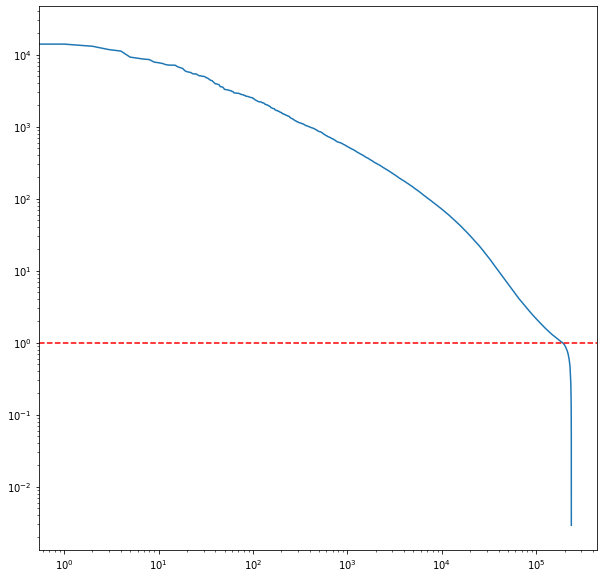

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x=range(len(relative_to_factor)), y=list(relative_to_factor.values()), ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(y=1, color='r', linestyle='--')

In [137]:
total_skip_trigrams = Counter()
total_skip_trigrams_per_row = Counter()

num_total_skip_trigrams = 0

for row, tokens in enumerate(tqdm.tqdm(validation_set)):
    skip_trigrams_in_row = set()

    for i in range(len(tokens)-2):
        for j in range(i+1, len(tokens)-2):
            skip_trigram = (tokens[i], tokens[j], tokens[j+1])
            total_skip_trigrams[skip_trigram] += 1
            skip_trigrams_in_row.add(skip_trigram)     
            num_total_skip_trigrams += 1

    for token in skip_trigrams_in_row:
        total_skip_trigrams_per_row[token] += 1

    if row > 0 and row % 1000 == 0:
        for trigram in tqdm.tqdm(list(total_skip_trigrams.keys()), desc="Cleaning"):
            if total_skip_trigrams_per_row[trigram] == 1:
                del total_skip_trigrams[trigram]
                del total_skip_trigrams_per_row[trigram]

for trigram in tqdm.tqdm(total_skip_trigrams.keys(), desc="Cleaning"):
    if total_skip_trigrams_per_row[trigram] == 1:
        del total_skip_trigrams[trigram]
        del total_skip_trigrams_per_row[trigram]
        
num_unique_skip_trigrams = len(total_skip_trigrams) # Note this has already discarded a lot of trigrams encountered
num_filtered_skip_trigrams = sum(v for v in total_skip_trigrams.values())
num_unique_skip_trigrams, num_total_skip_trigrams, num_filtered_skip_trigrams

Cleaning:  47%|████▋     | 24999659/53457707 [00:12<00:14, 1944565.18it/s]


RuntimeError: dictionary changed size during iteration

In [103]:
print("Number of unique trigrams in validation set:", len(total_skip_trigrams))
print("Number of unique trigrams with count > 1:", sum((1 for t in total_skip_trigrams if total_skip_trigrams[t] > 1)))
print("Number of unique trigrams with count > 2:", sum(1 for t in total_skip_trigrams if total_skip_trigrams[t] > 2))
print("Number of unique trigrams that show up in > 1 rows:", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 1))
print("Number of unique trigrams that show up in > 2 rows:", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 2))
print("Number of unique trigrams that show up in > 4 rows:", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 4))
print("Number of unique trigrams that show up in > 8 rows:", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 8))
print("Number of unique trigrams that show up in > 12 rows:", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 8))
print("Number of unique trigrams that show up in > 16 rows:", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 16))

Number of unique trigrams in validation set: 40205163
Number of unique trigrams with count > 1: 15759899
Number of unique trigrams with count > 2: 8686507
Number of unique trigrams that show up in > 1 rows: 6544088
Number of unique trigrams that show up in > 2 rows: 2816563


In [106]:
print("Number of unique trigrams with count > 1 (no space):", sum((1 for t in total_skip_trigrams if total_skip_trigrams[t] > 1 and 220 not in t)))
print("Number of unique trigrams with count > 2 (no space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams[t] > 2 and 220 not in t))
print("Number of unique trigrams that show up in > 1 rows (no space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 1 and 220 not in t))
print("Number of unique trigrams that show up in > 2 rows (no space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 2 and 220 not in t))
print("Number of unique trigrams that show up in > 4 rows (no space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 4 and 220 not in t))
print("Number of unique trigrams that show up in > 8 rows (no space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 8 and 220 not in t))
print("Number of unique trigrams that show up in > 12 rows (no space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 8 and 220 not in t))
print("Number of unique trigrams that show up in > 16 rows (no space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 16 and 220 not in t))

Number of unique trigrams with count > 1 (no space): 14287464
Number of unique trigrams with count > 2 (no space): 7674410
Number of unique trigrams that show up in > 1 rows (no space): 5506815
Number of unique trigrams that show up in > 2 rows (no space): 2202657
Number of unique trigrams that show up in > 4 rows (no space): 763766
Number of unique trigrams that show up in > 8 rows (no space): 239317
Number of unique trigrams that show up in > 12 rows (no space): 239317
Number of unique trigrams that show up in > 16 rows (no space): 71125


In [107]:
print("Number of unique trigrams with count > 1 (no init space):", sum((1 for t in total_skip_trigrams if total_skip_trigrams[t] > 1 and t[0] != 220)))
print("Number of unique trigrams with count > 2 (no init space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams[t] > 2 and t[0] != 220))
print("Number of unique trigrams that show up in > 1 rows (no init space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 1 and t[0] != 220))
print("Number of unique trigrams that show up in > 2 rows (no init space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 2 and t[0] != 220))
print("Number of unique trigrams that show up in > 4 rows (no init space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 4 and t[0] != 220))
print("Number of unique trigrams that show up in > 8 rows (no init space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 8 and t[0] != 220))
print("Number of unique trigrams that show up in > 12 rows (no init space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 8 and t[0] != 220))
print("Number of unique trigrams that show up in > 16 rows (no init space):", sum(1 for t in total_skip_trigrams if total_skip_trigrams_per_row[t] > 16 and t[0] != 220))

Number of unique trigrams with count > 1 (no init space): 15618714
Number of unique trigrams with count > 2 (no init space): 8546960
Number of unique trigrams that show up in > 1 rows (no init space): 6495676
Number of unique trigrams that show up in > 2 rows (no init space): 2787257
Number of unique trigrams that show up in > 4 rows (no init space): 1084229
Number of unique trigrams that show up in > 8 rows (no init space): 406237
Number of unique trigrams that show up in > 12 rows (no init space): 406237
Number of unique trigrams that show up in > 16 rows (no init space): 151166


In [108]:
# Most common
for i, t in enumerate(total_skip_trigrams.most_common(100)):
    strs = tuple(translate_int_to_str(t[0], model))
    print("".join(strs), "\t\t\t", tuple(translate_int_to_str(t[0], model)), "\t\t\t", t[1])

  the 			 (' ', ' ', 'the') 			 550436
  and 			 (' ', ' ', 'and') 			 206816
  to 			 (' ', ' ', 'to') 			 187769
  a 			 (' ', ' ', 'a') 			 177928
the the 			 ('the', ' ', 'the') 			 174172
 

 			 (' ', '\n', '\n') 			 143792
  th 			 (' ', ' ', 'th') 			 125204
, the 			 (',', ' ', 'the') 			 123400
 ,  			 (' ', ',', ' ') 			 120184

 the 			 ('\n', ' ', 'the') 			 109650
  of  			 (' ', ' of', ' ') 			 104804
 .
 			 (' ', '.', '\n') 			 103814
. the 			 ('.', ' ', 'the') 			 101418
  t 			 (' ', ' ', 't') 			 89776
 of the 			 (' of', ' ', 'the') 			 76558
a the 			 ('a', ' ', 'the') 			 69202
 that 			 (' ', 'th', 'at') 			 67840
and the 			 ('and', ' ', 'the') 			 67065
  in  			 (' ', ' in', ' ') 			 66046
the and 			 ('the', ' ', 'and') 			 62452
to the 			 ('to', ' ', 'the') 			 57576
 to  			 (' ', 'to', ' ') 			 56647
the to 			 ('the', ' ', 'to') 			 56277
the a 			 ('the', ' ', 'a') 			 52421
 in the 			 (' in', ' ', 'the') 			 51240
, and 			 (',', ' ', 'and') 			 509

In [132]:
total_skip_trigrams_dict = dict(total_skip_trigrams)

for trigram in tqdm.tqdm(total_skip_trigrams, total=len(total_skip_trigrams_dict)):
    if total_skip_trigrams_per_row[trigram] < 2 or trigram in total_trigrams_per_row:
        del total_skip_trigrams_dict[trigram]
        continue

    unigram1 = unigrams[trigram[0]]
    unigram2 = unigrams[trigram[1]]
    bigram = bigrams[trigram[1], trigram[2]]

    null_prob = unigram1 * unigram2 * bigram
    total_skip_trigrams_dict[trigram] /= null_prob * num_total_skip_trigrams

# Sort by frequency
total_skip_trigrams_dict = {k: v  for k, v in tqdm.tqdm(sorted(total_skip_trigrams_dict.items(), key=lambda item: item[1], reverse=True), total=len(total_skip_trigrams_dict))}


100%|██████████| 6104275/6104275 [00:05<00:00, 1201981.48it/s]


In [133]:
preview_trigrams_dict(total_skip_trigrams_dict, model)

----- Top 1000 trigrams -----
[' Bit', 'ing', ' Bit']: 118386.57130305818
['coin', 'ing', ' Bit']: 105624.60198847554
['..', ' same', '..']: 104378.38256166862
['�', '�', '\n']: 46831.466762458425
['oh', 'u', ' rele']: 35486.87276392847
[' dat', ' species', ' during']: 33146.6997868504
[' crime', ' red', ' cost']: 30980.57178813649
[' studies', ' support', ' non']: 30259.159176487927
['bers', 'u', ' rele']: 27483.115332806996
[' Ag', ' same', '..']: 26750.38401517876
['coin', 'coin', ',']: 25636.516656791242
['aith', 'aith', ' in']: 25035.58861649418
[' gain', ' TV', ' execut']: 23583.577552771538
['�', 'ities', ' �']: 22529.335007908645
[' Bit', ' Bit', 'coin']: 22035.693314019853
[' greater', ' personal', ' fr']: 21770.246787867745
['�', '�', '\n']: 21551.34503973925
['coin', ' Bit', 'coin']: 21371.02435187529
[' station', 'ption', ' Michael']: 20628.35043505859
['�', '�', '\n']: 20442.681938710237
['�', '�', '\n']: 20347.77820962115
[' TV', ' TV', ' execut']: 19232.98372758534
[' ne

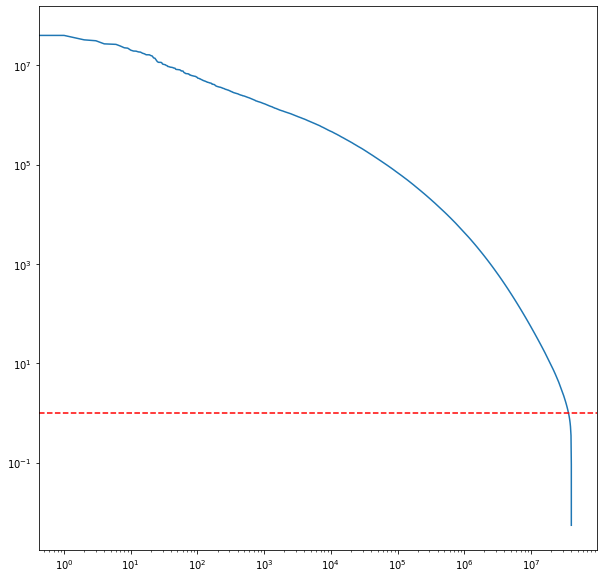

In [122]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x=range(len(total_skip_trigrams_dict)), y=list(total_skip_trigrams_dict.values()), ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(y=1, color='r', linestyle='--')